# Train MLP (1 hidden layer) for different stimulus 

This was trained on google colab 

## Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Courses/Winter 2021/tda/TDA-class-Winter2021/proj")


Mounted at /content/drive


In [5]:
import os, picklem re
import numpy as np 
from tqdm.notebook import tqdm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams, font_manager
import seaborn as sns

%matplotlib inline

rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')

# use one of the available styles 
plt.style.use('seaborn-notebook')

# further customization
rcParams['font.family'] = 'FreeSans'
rcParams['font.size'] = 15

rcParams['axes.titlesize'] = 15
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.linewidth'] = 1
rcParams['lines.linewidth'] = 2 

rcParams['mathtext.fontset'] = 'cm' 
rcParams['mathtext.rm'] = 'serif'
rcParams['figure.dpi'] = 160


In [ ]:
# get inputs
def get_inputs(sources, norm=True):
    Xs = [] 
    for i, src in enumerate(sources): 
        keys = src['name']
        with open(src['path'], 'rb') as f:
            X = pickle.load(f)
        for k in keys: 
            X = X[k]

        if i == 0: 
            Xs = X
        else:
            Xs = np.vstack([np.concatenate((x1,x2)) for x1,x2 in zip(Xs,X)])
    if norm:
        Xs = stats.zscore(Xs, axis=0)
        Xs = Xs[:,(~np.isnan(np.mean(Xs,axis=0)))]
    return Xs

# dataset loader
class StimTypeDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data, self.label = data, label
        self.transform = transform
        
    def __getitem__(self, i):
        sample_data, sample_label = torch.from_numpy(self.data[i]).float(), int(self.label[i])
        if self.transform:
            sample_data = self.transform(sample_data)
        return sample_data, sample_label
    
    def __len__(self):
        return len(self.data)

# MLP models (vanilla vs batchnorm)
class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.layer1 =  nn.Linear(num_inputs, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # need to flatten x
        bs, _ = x.shape
        x = x.view(bs, -1)  
        
        x = self.layer1(x)
        x = torch.tanh(x)

        x = self.layer2(x)
        x = torch.tanh(x)
        
        x = torch.log_softmax(x, dim=1)        
        return x

class MLPNetBN(nn.Module):
    def __init__(self):
        super(MLPNetBN, self).__init__()
        self.layer1 =  nn.Linear(num_inputs, num_hidden)
        self.batchnorm = nn.BatchNorm1d(num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # need to flatten x
        bs, _ = x.shape
        x = x.view(bs, -1)  
        
        x = self.layer1(x)
        x = self.batchnorm(x)
        x = torch.tanh(x)

        x = self.layer2(x)
        x = torch.tanh(x)
        
        x = torch.log_softmax(x, dim=1)        
        return x

# train loop
def train(model, device, train_loader, optimizer, epoch, log_interval=10, print_log=False):
    model.train()  # put model to train mode
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            if print_log:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
            losses.append(loss.item())
            
    return losses

# test routine
def test(model, device, test_loader, print_log=False):
    model.eval()  # put model in evaluation mode
    test_loss = 0
    correct = 0
    classif_perf = {'true': [], 'pred': []}
    with torch.no_grad():  # not accumulating gradients
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            classif_perf['true'].append(target.flatten())
            classif_perf['pred'].append(pred.flatten())
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    if print_log:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), accuracy))
            
    classif_perf = {k: torch.cat(v).cpu().numpy() for k,v in classif_perf.items()}
    return test_loss, accuracy, classif_perf

# train and test for each model
def training_and_testing(model, device, train_loader, test_loader, optim_fun, lr, print_log):
    model = model.to(device)  # send model to device

    optimizer = optim_fun(model.parameters(), lr=lr)

    train_loss, test_loss, test_accuracy = [], [], []

    loss, accuracy, _ = test(model, device, test_loader)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

    for epoch in range(epoch_nb):
        # train for 1 epoch
        losses = train(model, device, train_loader, optimizer, epoch, log_interval=log_interval, print_log=print_log)
        train_loss += losses
        # test at the end of epoch
        loss, accuracy, classif_perf = test(model, device, test_loader, print_log=print_log)
        test_loss.append(loss)
        test_accuracy.append(accuracy)
    
    model_stats = dict(
        train_loss = train_loss, 
        test_loss  = test_loss, 
        test_accuracy = test_accuracy, 
        classif_perf = classif_perf
    )
    return model_stats

# train and test with cross validation of holding out 
def evaluate_model_crossval(num_gen, inputs, outputs, num_testpergroup_split, 
                            model_name, device, optim_fun, lr, 
                            print_log=False, tqdm_opts=dict()):
    model_stats_list = []
    for _ in tqdm(range(num_gen),**tqdm_opts):
        X_train, X_test, Y_train, Y_test = train_test_split(inputs, outputs, 
            test_size=num_classes*num_testpergroup_split, stratify=outputs)
        train_ds = StimTypeDataset(X_train, Y_train)
        test_ds = StimTypeDataset(X_test, Y_test)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

        if model_name == 'vanilla':
            model = MLPNet()
        elif model_name == 'batchnorm':
            model = MLPNetBN()

        model_stats_list.append(
            training_and_testing(model, device, train_loader, test_loader,
                                 optim_fun, lr, print_log)
        )
    
    progress_keys = ['train_loss', 'test_loss', 'test_accuracy']
    classif_keys = ['pred', 'true']

    model_perf = {k: np.vstack([x[k] for x in model_stats_list]) 
                  for k in progress_keys}
    model_perf['classif_perf'] = {k: np.concatenate([x['classif_perf'][k] 
                                                     for x in model_stats_list])
                                  for k in classif_keys}
    return model_perf

## Loading inputs and outputs 

In [73]:
stim_path = 'data/preprocessed/purkpop-stim.pkl'
with open(stim_path, 'rb') as f: 
    stim_info = pickle.load(f)
    
stim_type_vec = stim_info['stim_types']
unq_stim_types = ['C', 'L', 'S', 'P', 'LS', 'LP', 'SP', 'LPS'] # manual sort
stim_type_ind = {k:np.where(stim_type_vec == k)[0] for k in unq_stim_types}

label2id_dict = {k:i for i,k in enumerate(unq_stim_types)}
id2label_dict = {i:k for i,k in enumerate(unq_stim_types)}
Ys = np.array([label2id_dict[x] for x in stim_type_vec])

In [74]:
# input data sources
data_sources = [
    dict(
        path = 'data/preprocessed/multisensory-activity-features.pkl',
        name = ['activity_features', 'dmean'] 
    ), 
    dict(
        path = 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl',  
        name = ['scalar_barfeats']
    ),
    dict(
        path = 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl',  
        name = ['betti_curves']
    )
]

## Training

In [ ]:
num_hidden = 50
batch_size = 5
num_testpergroup_split = 1
print_log = False

num_classes = len(unq_stim_types)

num_gen = 100
log_interval = 10

lr_dict = {'SGD': 0.05, 'Adam': 1e-3}
optim_fun_dict = {'SGD': optim.SGD, 'Adam': optim.Adam}

device = torch.device('cuda:0')
epoch_nb = 12

In [ ]:
source_ind_combos = [[0],[1],[2],[0,1],[0,2],[1,2],[0,1,2]]
for inds in tqdm(source_ind_combos, desc='Main progress', ncols='40%'):
    print('-'*150)
    sources = [data_sources[x] for x in inds]
    file_name_saved = '-'.join([x['name'][-1] for x in sources])
    Xs = get_inputs(sources, norm=True)
    num_inputs = len(Xs[0])

    training_results = {}
    print(sources)
    for key in lr_dict.keys():
        lr = lr_dict[key]
        optim_fun = optim_fun_dict[key]
        training_results[key] = {}

        for net_name in ['vanilla', 'batchnorm']:
            training_results[key][net_name] = evaluate_model_crossval(
                num_gen=num_gen, inputs=Xs, outputs=Ys, 
                num_testpergroup_split=num_testpergroup_split, 
                model_name=net_name, device=device, 
                optim_fun=optim_fun, lr=lr, 
                print_log=False,
                tqdm_opts=dict(
                    desc = '+ %s - %s' %(net_name, key),
                    ncols = '30%'
                )
            )
    with open('data/processed/mlp-results-' + file_name_saved + '.pkl', 'wb') as f: 
        pickle.dump(dict(
            data_sources = data_sources, 
            training_results = training_results
        ), f)        
    

------------------------------------------------------------------------------------------------------------------------------------------------------
[{'path': 'data/preprocessed/multisensory-activity-features.pkl', 'name': ['activity_features', 'dmean']}]



------------------------------------------------------------------------------------------------------------------------------------------------------
[{'path': 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl', 'name': ['scalar_barfeats']}]


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd



------------------------------------------------------------------------------------------------------------------------------------------------------
[{'path': 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl', 'name': ['betti_curves']}]



------------------------------------------------------------------------------------------------------------------------------------------------------
[{'path': 'data/preprocessed/multisensory-activity-features.pkl', 'name': ['activity_features', 'dmean']}, {'path': 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl', 'name': ['scalar_barfeats']}]


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd



------------------------------------------------------------------------------------------------------------------------------------------------------
[{'path': 'data/preprocessed/multisensory-activity-features.pkl', 'name': ['activity_features', 'dmean']}, {'path': 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl', 'name': ['betti_curves']}]



------------------------------------------------------------------------------------------------------------------------------------------------------
[{'path': 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl', 'name': ['scalar_barfeats']}, {'path': 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl', 'name': ['betti_curves']}]


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd



------------------------------------------------------------------------------------------------------------------------------------------------------
[{'path': 'data/preprocessed/multisensory-activity-features.pkl', 'name': ['activity_features', 'dmean']}, {'path': 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl', 'name': ['scalar_barfeats']}, {'path': 'data/processed/multisensory-tdafeats-original-pertrial-withdist-var_info.pkl', 'name': ['betti_curves']}]


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


## Plot training progress 

In [70]:
!ls data/processed/mlp-results*

file_name = 'data/processed/mlp-results-dmean.pkl'

with open(file_name, 'rb') as f:
   training_results = pickle.load(f)['training_results']

data/processed/mlp-results-betti_curves.pkl
data/processed/mlp-results-dmean-betti_curves.pkl
data/processed/mlp-results-dmean.pkl
data/processed/mlp-results-dmean-scalar_barfeats-betti_curves.pkl
data/processed/mlp-results-dmean-scalar_barfeats.pkl
data/processed/mlp-results-scalar_barfeats-betti_curves.pkl
data/processed/mlp-results-scalar_barfeats.pkl


<Figure size 3200x800 with 0 Axes>

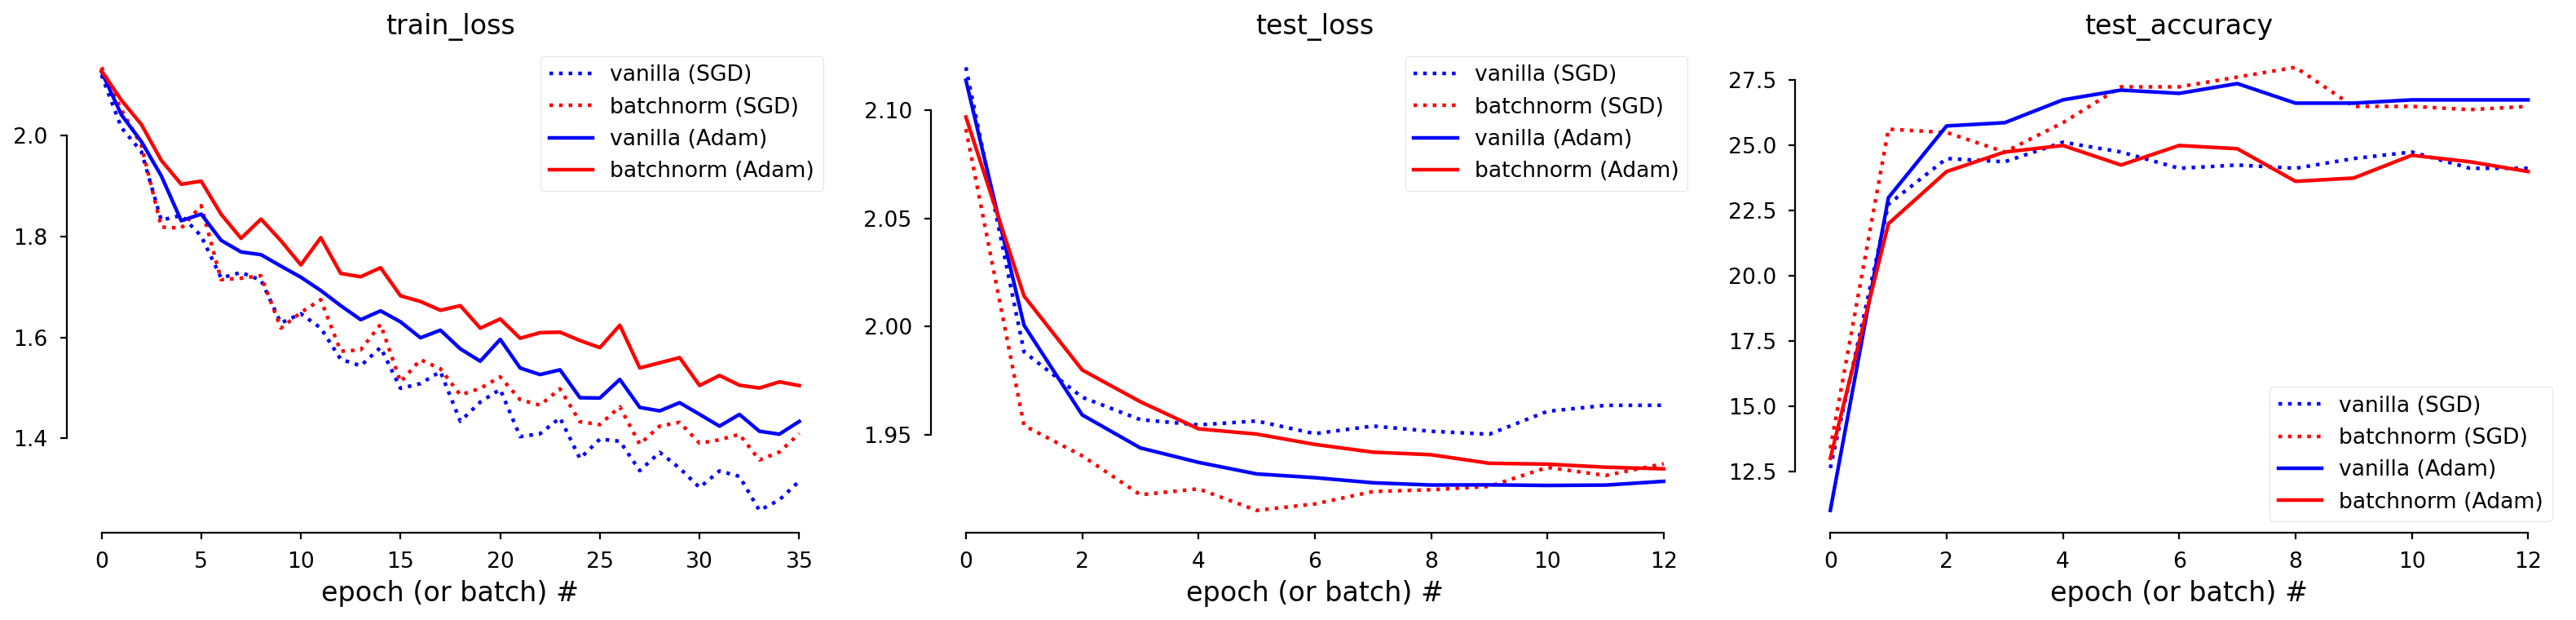

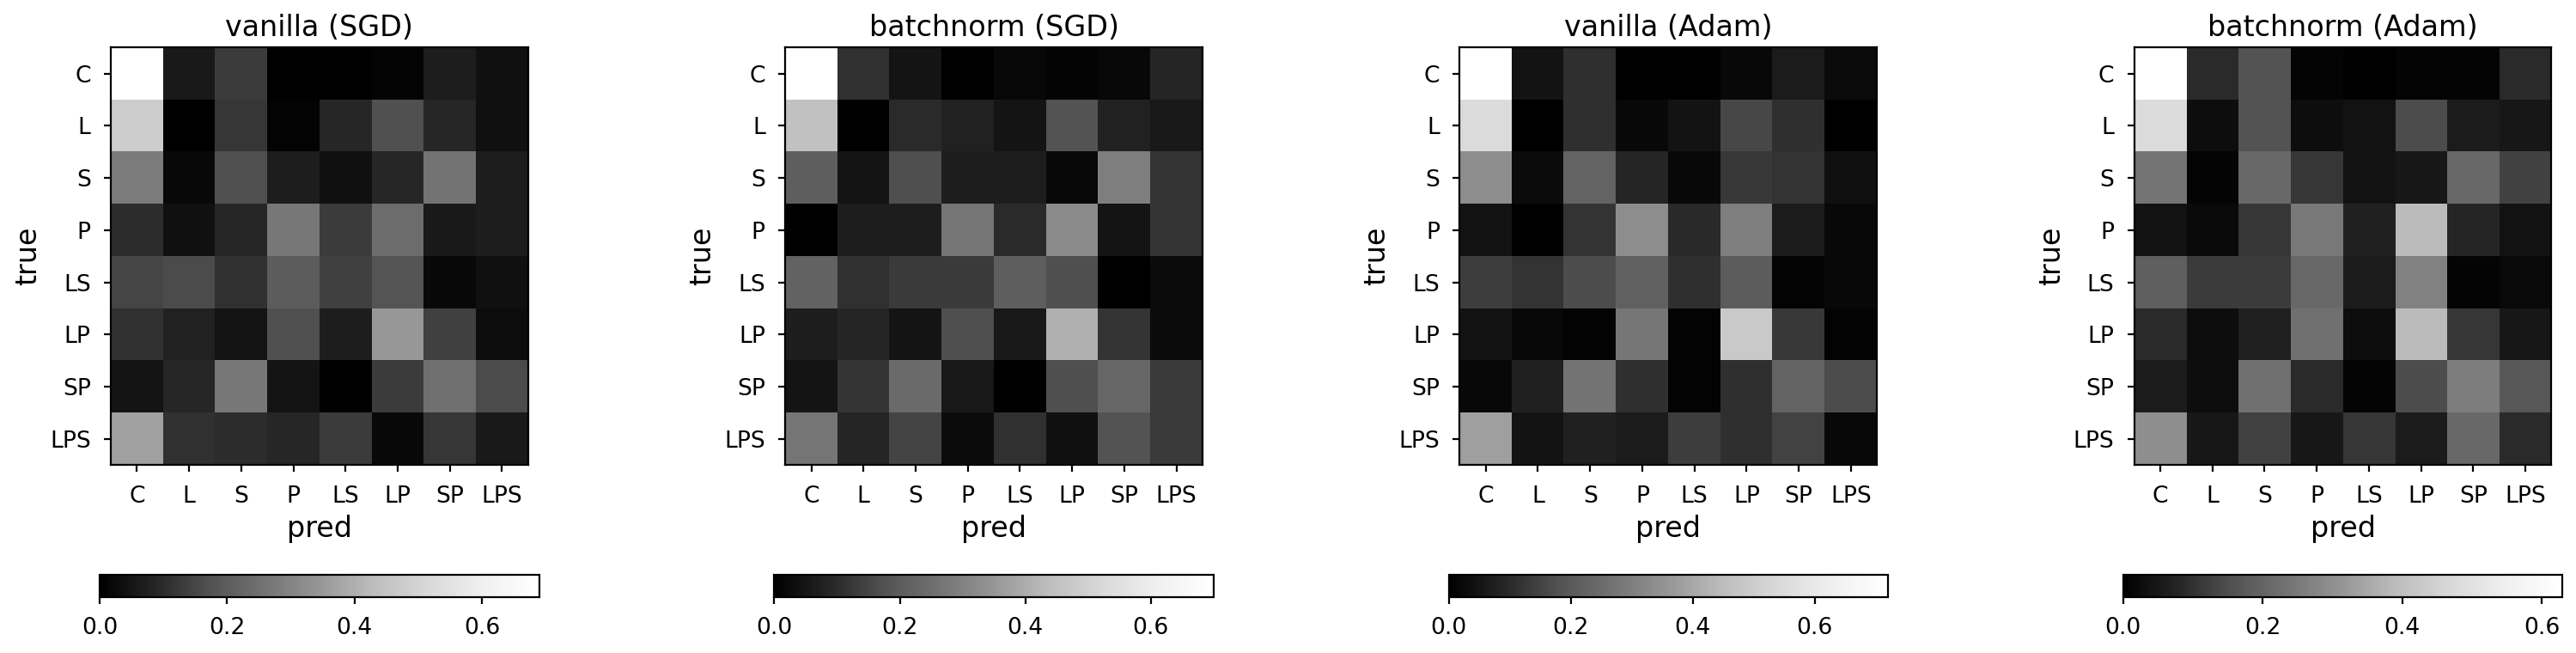

In [75]:
plt.figure(figsize=(20,5))

linstyles = {'SGD': ':', 'Adam': '-'}

main_keys = ['train_loss', 'test_loss', 'test_accuracy']

for (cnt, key) in enumerate(main_keys):
    plt.subplot(1,3,cnt+1)

    for optim_meth in training_results.keys():

        plt.plot(np.mean(training_results[optim_meth]['vanilla'][key],axis=0), 
                 label='vanilla (%s)' %(optim_meth), 
                 lw=2, c='b', linestyle=linstyles[optim_meth])
        plt.plot(np.mean(training_results[optim_meth]['batchnorm'][key],axis=0), 
                 label='batchnorm (%s)' %(optim_meth), 
                 lw=2, c='r', linestyle=linstyles[optim_meth])

    lgnd = plt.legend()
    plt.title(key)
    plt.xlabel('epoch (or batch) #')
    sns.despine(trim=True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,5))

tick_vals = list(label2id_dict.values())
tick_lbls = list(label2id_dict.keys())
cnt_splt = 1
for optim_meth in training_results.keys():
    for net_name in ['vanilla','batchnorm']:
        classif_perf = training_results[optim_meth][net_name]['classif_perf']
        conf_mat = confusion_matrix(classif_perf['true'],classif_perf['pred'],normalize='true')
        plt.subplot(1,4,cnt_splt)
        # im = plt.imshow(np.log(conf_mat),cmap='Greys_r',vmin=-3,vmax=0)
        im = plt.imshow(conf_mat,cmap='Greys_r')
        plt.xticks(ticks=tick_vals,labels=tick_lbls)
        plt.yticks(ticks=tick_vals,labels=tick_lbls)
        plt.title('%s (%s)' %(net_name, optim_meth))
        plt.ylabel('true')
        plt.xlabel('pred')
        
        plt.colorbar(im, fraction=0.04, pad=0.2, orientation='horizontal')
        cnt_splt += 1
plt.tight_layout()
plt.show()

## Summary table generations

In [112]:
def replace_multi(text, rep):
    """ Replace multiple patterns with multple replacements
    from: https://stackoverflow.com/a/6117124
    """
    rep = dict((re.escape(k), v) for k, v in rep.items()) 
    pattern = re.compile("|".join(rep.keys()))
    return pattern.sub(lambda m: rep[re.escape(m.group(0))], text)

In [118]:
variations = {
    'dmean': 'data/processed/mlp-results-dmean.pkl',
    'barfeat': 'data/processed/mlp-results-scalar_barfeats.pkl',
    'betticurve': 'data/processed/mlp-results-betti_curves.pkl',
    'dmean,barfeat': 'data/processed/mlp-results-dmean-scalar_barfeats.pkl',
    'dmean,betticurve': 'data/processed/mlp-results-dmean-betti_curves.pkl',
    'barfeat,betticurve': 'data/processed/mlp-results-scalar_barfeats-betti_curves.pkl',
    'dmean,barfeat,betticurve': 'data/processed/mlp-results-dmean-scalar_barfeats-betti_curves.pkl'
}

names2latex = {
    'vanilla': 'mlp', 
    'batchnorm': 'bn',
    'dmean': '$\\Delta$',
    'barfeat': '$\\phi$',
    'betticurve': '$\\beta$'
}

test_accs = {'mean': {}, 'ci': {}, 'max': {}}
z_factor = 1.960
for trained_on,file_name in variations.items():
    with open(file_name, 'rb') as f:
        training_results = pickle.load(f)['training_results']

    test_accs['mean'][trained_on] = {}
    test_accs['ci'][trained_on] = {}
    test_accs['max'][trained_on] = {}

    for optim_meth in training_results.keys():
        for model_type in ['vanilla', 'batchnorm']: 
            V = training_results[optim_meth][model_type]['test_accuracy'][:,-1]
            test_accs['mean'][trained_on]['%s-%s' %(model_type,optim_meth)] = np.mean(V)
            test_accs['ci'][trained_on]['%s-%s' %(model_type,optim_meth)] = z_factor*np.std(V)/np.sqrt(len(V))
            test_accs['max'][trained_on]['%s-%s' %(model_type,optim_meth)] = np.max(V)

df_testaccs = {k: pd.DataFrame(v) for k,v in test_accs.items()}          

In [114]:
[print('table of ' + k) or display(v) or print('-'*125 + '\n') for k,v in df_testaccs.items()];

table of mean


,dmean,barfeat,betticurve,"dmean,barfeat","dmean,betticurve","barfeat,betticurve","dmean,barfeat,betticurve"
vanilla-SGD,24.125,17.250,17.375,27.500,22.125,18.875,26.500
batchnorm-SGD,26.500,17.500,17.750,26.750,21.500,16.875,21.500
vanilla-Adam,26.750,18.000,15.125,27.250,21.875,15.125,25.875
batchnorm-Adam,24.000,19.875,16.250,25.625,22.875,15.500,23.500


-----------------------------------------------------------------------------------------------------------------------------

table of ci


,dmean,barfeat,betticurve,"dmean,barfeat","dmean,betticurve","barfeat,betticurve","dmean,barfeat,betticurve"
vanilla-SGD,2.598733,2.239573,2.613474,2.836080,2.421785,2.362567,2.799440
batchnorm-SGD,3.273845,2.615884,2.454406,3.001025,2.274149,2.333938,2.594688
vanilla-Adam,2.593299,2.457827,2.357481,2.927314,2.844006,2.279817,2.381798
batchnorm-Adam,2.912925,2.571800,2.093281,2.885909,2.475713,2.194631,2.799440


-----------------------------------------------------------------------------------------------------------------------------

table of max


,dmean,barfeat,betticurve,"dmean,barfeat","dmean,betticurve","barfeat,betticurve","dmean,barfeat,betticurve"
vanilla-SGD,62.5,50.0,50.0,62.5,62.5,50.0,62.5
batchnorm-SGD,75.0,50.0,62.5,75.0,50.0,50.0,62.5
vanilla-Adam,62.5,50.0,62.5,62.5,62.5,37.5,62.5
batchnorm-Adam,62.5,75.0,50.0,75.0,50.0,50.0,50.0


-----------------------------------------------------------------------------------------------------------------------------



In [119]:
df_template = df_testaccs['mean'].copy(deep=True)

mat = df_template.to_numpy()
mat_argmax = np.argmax(mat,axis=0)
mask = np.hstack([np.arange(mat.shape[0])[:,None] == x for x in mat_argmax])

def format_table(mu,ci,m):
    s = '%.2f \\pm %.2f' %(mu, ci)
    if m: s = '\\mathbf{%s}' %(s)
    return '$%s$' %(s)
df_template[:] = np.vectorize(format_table)(mat,  df_testaccs['ci'].to_numpy(), mask)

replace_multi(df_template.to_latex(escape=False),names2latex)

'\\begin{tabular}{llllllll}\n\\toprule\n{} &                      $\\Delta$ &                    $\\phi$ &                 $\\beta$ &              $\\Delta$,$\\phi$ &           $\\Delta$,$\\beta$ &         $\\phi$,$\\beta$ &   $\\Delta$,$\\phi$,$\\beta$ \\\\\n\\midrule\nmlp-SGD    &           $24.12 \\pm 2.60$ &           $17.25 \\pm 2.24$ &           $17.38 \\pm 2.61$ &  $\\mathbf{27.50 \\pm 2.84}$ &           $22.12 \\pm 2.42$ &  $\\mathbf{18.88 \\pm 2.36}$ &  $\\mathbf{26.50 \\pm 2.80}$ \\\\\nbn-SGD  &           $26.50 \\pm 3.27$ &           $17.50 \\pm 2.62$ &  $\\mathbf{17.75 \\pm 2.45}$ &           $26.75 \\pm 3.00$ &           $21.50 \\pm 2.27$ &           $16.88 \\pm 2.33$ &           $21.50 \\pm 2.59$ \\\\\nmlp-Adam   &  $\\mathbf{26.75 \\pm 2.59}$ &           $18.00 \\pm 2.46$ &           $15.12 \\pm 2.36$ &           $27.25 \\pm 2.93$ &           $21.88 \\pm 2.84$ &           $15.12 \\pm 2.28$ &           $25.88 \\pm 2.38$ \\\\\nbn-Adam &           $24.00 \\pm 2.91$ &  $\\ma

In [120]:
df_template = df_testaccs['max'].copy(deep=True)

mat = df_template.to_numpy()
mat_argmax = np.argmax(mat,axis=0)
mask = np.hstack([np.arange(mat.shape[0])[:,None] == x for x in mat_argmax])

def format_table(v,m):
    s = '%.2f' %(v)
    if m: s = '\\mathbf{%s}' %(s)
    return '$%s$' %(s)
df_template[:] = np.vectorize(format_table)(mat, mask)
replace_multi(df_template.to_latex(escape=False),names2latex)

'\\begin{tabular}{llllllll}\n\\toprule\n{} &             $\\Delta$ &           $\\phi$ &        $\\beta$ &     $\\Delta$,$\\phi$ &  $\\Delta$,$\\beta$ & $\\phi$,$\\beta$ & $\\Delta$,$\\phi$,$\\beta$ \\\\\n\\midrule\nmlp-SGD    &           $62.50$ &           $50.00$ &           $50.00$ &           $62.50$ &  $\\mathbf{62.50}$ &   $\\mathbf{50.00}$ &         $\\mathbf{62.50}$ \\\\\nbn-SGD  &  $\\mathbf{75.00}$ &           $50.00$ &  $\\mathbf{62.50}$ &  $\\mathbf{75.00}$ &           $50.00$ &            $50.00$ &                  $62.50$ \\\\\nmlp-Adam   &           $62.50$ &           $50.00$ &           $62.50$ &           $62.50$ &           $62.50$ &            $37.50$ &                  $62.50$ \\\\\nbn-Adam &           $62.50$ &  $\\mathbf{75.00}$ &           $50.00$ &           $75.00$ &           $50.00$ &            $50.00$ &                  $50.00$ \\\\\n\\bottomrule\n\\end{tabular}\n'